# 检索召回

检索与召回是RAG的核心

## 向量查询

我们加载上一节使用的向量数据库

In [ ]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

#API_KEY = "YOUR_TONG_API_KEY"
#os.environ["AZURE_OPENAI_API_KEY"] = API_KEY

REGION = "canadaeast"
API_BASE = "https://api.tonggpt.mybigai.ac.cn/proxy"
ENDPOINT = f"{API_BASE}/{REGION}"

openai.azure_endpoint = ENDPOINT
os.environ["AZURE_OPENAI_ENDPOINT"] = ENDPOINT
os.environ["OPENAI_API_VERSION"] = "2024-02-01"

### 相似度搜索

In [ ]:
from langchain.vectorstores import Chroma
from chromadb.utils import embedding_functions
from langchain_core.embeddings import Embeddings
from typing import List
default_ef = embedding_functions.DefaultEmbeddingFunction()


class DefaultChromaEmbedding(Embeddings):
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return default_ef(texts)

    def embed_query(self, text: str) -> List[float]:
        return default_ef([text])[0]

chroma_embedding = DefaultChromaEmbedding()

In [ ]:
persist_directory = 'docs/data/chroma/'

vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=chroma_embedding
)

In [ ]:
print(vectordb._collection.count())

In [ ]:
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

In [ ]:
smalldb = Chroma.from_texts(texts, embedding=chroma_embedding)

In [ ]:
question = "Tell me about all-white mushrooms with large fruiting bodies"

In [ ]:
smalldb.similarity_search(question, k=3)

### 提升多样性：最大边际相关 - Maximum marginal relevance

基于向量的搜索返回的结果最大化向量相似度，其结果不一定全面。如何提升结果的多样性则是一个问题。  
`Maximum marginal relevance` 试图在 *相关性 relevance* 和 *多样性 diversity* 间找到平衡  


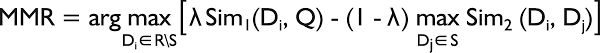

In [ ]:
question = "what did they say about matlab?"
docs_ss = vectordb.similarity_search(question,k=3)

In [ ]:
docs_ss[0].page_content[:100]

In [ ]:
docs_ss[1].page_content[:100]

使用 `MMR` 会得到不一样的结果

In [ ]:
docs_mmr = vectordb.max_marginal_relevance_search(question,k=3)

In [ ]:
docs_mmr[0].page_content[:100]

In [ ]:
docs_mmr[1].page_content[:100]

### 提升特异性 (specifity): 元信息过滤

我们可以通过元信息(metadata) 的过滤，实现对特定类别文件的搜索。  
元信息通常包含embedding 文件的类别，文件名和标签等基本信息。

In [ ]:
question = "what did they say about regression in the third lecture?"

In [ ]:
docs = vectordb.similarity_search(
    question,
    k=3,
    filter={"source":"docs/cs229_lectures/MachineLearning-Lecture03.pdf"}
)

In [ ]:
for d in docs:
    print(d.metadata)

### 提升特异性: 自查询召回
使用元信息进行过滤固然可行，但能不能通过query 本身推测元信息的过滤呢？  
顺着这个方向，我们可以使用 `SelfQueryRetriever`，基于LLM进行信息提取：
1. `query`，用来查询的字符串
2. 元信息的过滤语句

大多数向量数据库都支持元信息过滤，以下继续使用Chroma 作为向量引擎

In [ ]:
from langchain.llms import OpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

In [ ]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The lecture the chunk is from, should be one of `docs/cs229_lectures/MachineLearning-Lecture01.pdf`, `docs/cs229_lectures/MachineLearning-Lecture02.pdf`, or `docs/cs229_lectures/MachineLearning-Lecture03.pdf`",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the lecture",
        type="integer",
    ),
]

In [ ]:
! pip install lark

In [ ]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment="gpt-35-turbo-0125",  # or your deployment
    temperature=0)

In [ ]:
document_content_description = "Lecture notes"

retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [ ]:
question = "what did they say about regression in the third lecture?"

In [ ]:
docs = retriever.get_relevant_documents(question)

In [ ]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\nsource: {d.metadata["source"]}\n\n" + d.page_content for i, d in enumerate(docs)]))

In [ ]:
pretty_print_docs(docs)

### 其他方法: 压缩

很多时候真正有意义，相关的信息被淹没在大段无关的文本信息里。如果直接将整段文本推给LLM，其准确度和性能都不会很好 (同时还会很贵)。    
基于上下文的压缩可以有效解决这一问题。

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

In [ ]:
# Wrap our vectorstore
compressor = LLMChainExtractor.from_llm(llm)

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

## 综合上述方法

In [ ]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever(search_type = "mmr")
)

In [ ]:
question = "what did they say about matlab?"
compressed_docs = compression_retriever.get_relevant_documents(question)
pretty_print_docs(compressed_docs)

## 其他检索与召回策略

向量检索不是唯一的道路。  
`LangChain` retriever 抽象类支持了多种文档召回的实现，例如TF-IDF 和 SVM.  

In [ ]:
! pip install scikit-learn

In [ ]:
from langchain.retrievers import SVMRetriever
from langchain.retrievers import TFIDFRetriever
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# Load PDF
loader = PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf")
pages = loader.load()
all_page_text=[p.page_content for p in pages]
joined_page_text=" ".join(all_page_text)

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1500,chunk_overlap = 150)
splits = text_splitter.split_text(joined_page_text)


In [ ]:
# Retrieve
svm_retriever = SVMRetriever.from_texts(splits,chroma_embedding)
tfidf_retriever = TFIDFRetriever.from_texts(splits)

In [ ]:
question = "What are major topics for this class?"
docs_svm=svm_retriever.get_relevant_documents(question)
print(docs_svm[0].page_content)

In [ ]:
question = "what did they say about matlab?"
docs_tfidf=tfidf_retriever.get_relevant_documents(question)
print(docs_tfidf[0].page_content)